In [4]:
import pandas as pd
import unicodedata
import re
import html
import string
import pathlib

BASE_DIR = pathlib.Path.cwd().parent.resolve()
BASE_DIR

WindowsPath('C:/Users/ABRAHAM/Documents/GitHub/Practica-1')

In [2]:
def minusculas(texto: str) -> str:
    return texto.lower()

def eliminar_tildes(texto: str) -> str:
    normalized = unicodedata.normalize('NFD', texto)
    return ''.join([c for c in normalized if unicodedata.category(c) != 'Mn'])

def eliminar_numeros(texto: str) -> str:
    return re.sub(r'\d+', '', texto)

def eliminar_enlaces(texto: str) -> str:
    pattern = r"\b(?:https?://|www\.)\S+\b|\b(?:[A-Za-z0-9-]+\.)+[A-Za-z]{2,}(?:/\S*)?"
    return re.sub(pattern, "", texto, flags=re.IGNORECASE)

# ejecuta de ultimo
def eliminar_salto_linea(texto: str) -> str:
    # reemplaza CR/LF/tabs por un espacio y colapsa múltiples espacios
    texto = re.sub(r'[\r\n\t]+', ' ', texto)
    texto = re.sub(r'\s{2,}', ' ', texto).strip()
    return texto

def eliminar_html(texto: str) -> str:
    # Desescapa entidades HTML (ej. &nbsp; -> espacio)
    texto = html.unescape(texto)
    # Elimina etiquetas HTML
    texto = re.sub(r'<[^>]+>', '', texto)
    return texto.strip()

def eliminar_signos_puntuacion(texto: str) -> str:
    return texto.translate(str.maketrans('', '', string.punctuation))

def eliminar_emoticones(texto: str) -> str:
    # Patrón para emoticones textuales comunes
    emoticon_pattern = r'[:;][\-]?[\)\(DPOp]'
    # Patrón para emojis (rangos Unicode comunes)
    emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]'
    # Combina y elimina
    combined_pattern = f'({emoticon_pattern}|{emoji_pattern})'
    return re.sub(combined_pattern, '', texto)

def preprocesar_texto(texto: str) -> str:
    texto = minusculas(texto)
    texto = eliminar_tildes(texto)
    texto = eliminar_numeros(texto)
    texto = eliminar_enlaces(texto)
    texto = eliminar_html(texto)
    texto = eliminar_signos_puntuacion(texto)
    texto = eliminar_emoticones(texto)
    texto = eliminar_salto_linea(texto)  # Último
    return texto

In [8]:
noticias_fuente1 = pd.read_csv( '../data_scrapeada/noticias_combinadas.csv', usecols=['descripcion', 'veracidad'])
noticias_fuente1.columns = ['text', 'label']
noticias_fuente1['label'] = noticias_fuente1['label'].astype(bool)
noticias_fuente1.head()

,text,label
0,Distintas desinformaciones señalan falsamente ...,False
1,El metraje realmente corresponde a embarcacion...,False
2,Una cuenta desinformadora de derecha adelanta ...,False
3,Se trata de una suplantación que no ha sido pu...,False
4,Un video viral atribuye a Hugo “El Pollo” Carv...,False


In [9]:
noticias_fuente2 = pd.read_csv(BASE_DIR / './data/merge_data/full_dataset.csv')
noticias_fuente2.head()

,text,label
0,Algunas de las voces extremistas más conocida...,True
1,Después de casi dos años y medio de luchas po...,True
2,Dos periodistas birmanos de la agencia Reuter...,True
3,El Cuerpo Nacional de Policía ha detenido a c...,True
4,El desfile de la firma en Roma se convierte e...,True


In [10]:
noticias_combinadas = pd.concat([noticias_fuente1, noticias_fuente2], ignore_index=True)
noticias_combinadas['text'] = noticias_combinadas['text'].astype(str)
noticias_combinadas['label'] = noticias_combinadas['label'].astype(bool)

In [11]:
noticias_combinadas['text'] = noticias_combinadas['text'].apply(preprocesar_texto)
print(noticias_combinadas.shape)
noticias_combinadas.head()

(5518, 2)


,text,label
0,distintas desinformaciones senalan falsamente ...,False
1,el metraje realmente corresponde a embarcacion...,False
2,una cuenta desinformadora de derecha adelanta ...,False
3,se trata de una suplantacion que no ha sido pu...,False
4,un video viral atribuye a hugo “el pollo” carv...,False


label
True     2839
False    2679
Name: count, dtype: int64


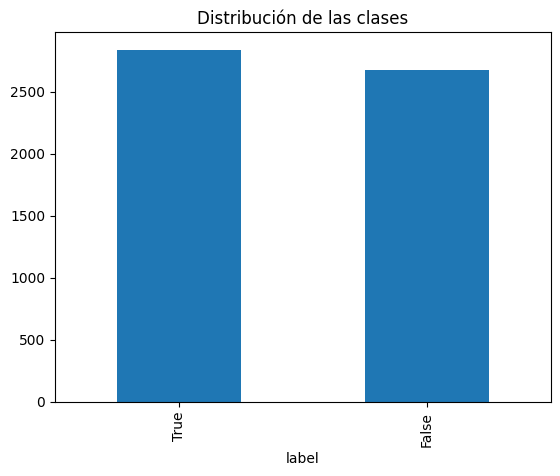

In [12]:
print(noticias_combinadas['label'].value_counts())
noticias_combinadas['label'].value_counts().plot(kind='bar', title='Distribución de las clases');

• Mean: La media es el promedio de palabras totales en cada archivo que
compone una fuente

• Std: La Desviación Estándar mide la dispersión de las longitudes respecto
a la media de palabras en cada archivo de la fuente

• Min: cantidad mínima de palabras entre las diferentes fuentes

• Max: cantidad mínima de palabras entre las diferentes fuentes

• Quartiles: Cuartiles (25%, 50% y 75%) de la cantidad de palabras entre
las diferentes fuentes

• Sum: Total de palabras de las diferentes fuentes

In [13]:
# meadia de palabras totales
print("Mean:", noticias_combinadas['text'].str.split().apply(len).mean())

# desviacion estandar de la longitud de palabras
print("Std Dev:", noticias_combinadas['text'].str.split().apply(len).std())

# cantidad minima de palabras
print("Min:", noticias_combinadas['text'].str.split().apply(len).min())

# cantidad maxima de palabras
print("Max:", noticias_combinadas['text'].str.split().apply(len).max())

# total de palabras
print("Sum:", noticias_combinadas['text'].str.split().apply(len).sum())

# cuartiles
print("Quartiles:")
print(noticias_combinadas['text'].str.split().apply(len).quantile([0.25, 0.5, 0.75]))

Mean: 182.20333454150054
Std Dev: 323.5017062877962
Min: 6
Max: 4647
Sum: 1005398
Quartiles:
0.25     40.00
0.50     44.00
0.75    240.75
Name: text, dtype: float64


In [15]:
noticias_combinadas.to_csv(BASE_DIR / 'data/clean_data/noticias_combinadas.csv', index=False)